# CS 480/680 assignment 4

Tips:
- Please save a copy of this notebook to avoid losing your changes.
- Debug your code and ensure that it can run.
- Save the output of each cell. Failure to do so may result in your coding questions not being graded.
- To accelerate the training time, you can choose 'Runtime' -> 'Change runtime type' -> 'Hardware accelerator' and set 'Hardware accelerator' to 'GPU'.
- Your grade is independent of the accuracy of your models. Your grade will depend on the correctness of your code and implementation.

Tips for submission:
- Do not change the order of the problems.
- Select 'Runtime' -> 'Run all' to run all cells and generate a final "gradable" version of your notebook and save your ipynb file.
- Also use 'File' -> 'Print' and then print your report from your browser into a PDF file.

##Question1 - Adversarial Training (55 points)

In this assignment, you are supposed to train a model using limited data that, in addition to generalization, also possesses good robustness.


You can add any extra libraries that you need in this cell.

In [47]:
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
import umap.umap_ as umap
from tqdm import tqdm
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import copy

In [48]:
# device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

Using device: mps


###Q1.1 Load Data (5 points)

In this question, you are going to use CIFAR-10 dataset. First, load this dataset, then split 20% of the data for training and the rest for validation. Make sure to maintain class balance during the split.

In [49]:
Train_SIZE = 0.2
cifar_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
class Cifar10Dataset(torch.utils.data.Dataset):

    def __init__(self,dataset,idx,transforms=None):
        self.idx = idx
        self.transforms = transforms
        self.data = torch.utils.data.Subset(dataset, idx)

    def __getitem__(self,index):
        image,label = self.data[index]
        if(self.transforms!= None):
            image = self.transforms(image)

        return image,label

    def __len__(self):
        return len(self.data)

#Split data and create the dataloader
targets = cifar_trainset.targets
train_idx, val_idx = train_test_split(np.arange(len(targets)), test_size=0.8, stratify=targets, random_state=42)
test_idx = list(range(len(cifar_testset)))

# Utilize the provided class Cifar10Dataset to create datasets 
train_dataset = Cifar10Dataset(cifar_trainset, train_idx, transforms=cifar_transforms)
val_dataset = Cifar10Dataset(cifar_trainset, val_idx, transforms=cifar_transforms)
test_dataset = Cifar10Dataset(cifar_testset, test_idx, transforms=cifar_transforms)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64,shuffle=False)

# Output the sizes of the training and validation datasets
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Training Dataset Size: 10000
Validation Dataset Size: 40000
Test Dataset Size: 10000


###Q1.2 Train Model (15 points)

Train a ResNet18 model using the cross-entropy loss function, and report its accuracy on validation and test datasets.

After that, reduce the dimensionality of the output of the backbone of the network and visualize it for the unseen data. You can use UMAP for dimensionality reduction. Note that for this task, you are not allowed to use the labels.

In [51]:
class Resnet18(nn.Module):
    def __init__(self, num_classes,normalize = False):
        super().__init__()
        #To do
        self.model = models.resnet18(pretrained = False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        #To do
        return self.model(x)

In [52]:
def train(model,data_loader,criterion,optimizer,attack = False):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, (inputs, targets) in enumerate(train_tqdm):
            model.train()
            inputs, targets = inputs.to(device), targets.to(device)
            #To do
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.detach(), 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100. * correct / total
    average_train_loss = total_loss / len(data_loader)
    return average_train_loss, accuracy

In [53]:
def test(model,data_loader,criterion,optimizer=None,attack=False):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        with tqdm(data_loader, desc ="   test") as test_tqdm:
            for batch_idx, (inputs, targets) in enumerate(test_tqdm):
                inputs, targets = inputs.to(device), targets.to(device)
                #To do
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

    accuracy = 100. * correct / total
    average_test_loss = total_loss / len(data_loader)
    return average_test_loss, accuracy

In [73]:
model = Resnet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 30  # Number of epochs to train for

# Train
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

# val
val_loss, val_accuracy = test(model, val_loader, criterion)
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# test
test_loss, test_accuracy = test(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

/Users/kaihangjiang/anaconda3/envs/mps_general/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kaihangjiang/anaconda3/envs/mps_general/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.53it/s]


Epoch 1/30 - Training Loss: 1.7312, Training Accuracy: 37.73%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.98it/s]


Epoch 2/30 - Training Loss: 1.3761, Training Accuracy: 50.66%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.11it/s]


Epoch 3/30 - Training Loss: 1.1943, Training Accuracy: 57.43%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:07<00:00, 21.07it/s]


Epoch 4/30 - Training Loss: 1.0330, Training Accuracy: 63.39%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:07<00:00, 22.39it/s]


Epoch 5/30 - Training Loss: 0.8662, Training Accuracy: 69.55%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.75it/s]


Epoch 6/30 - Training Loss: 0.7358, Training Accuracy: 74.26%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.64it/s]


Epoch 7/30 - Training Loss: 0.6249, Training Accuracy: 77.73%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.93it/s]


Epoch 8/30 - Training Loss: 0.5084, Training Accuracy: 82.29%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:07<00:00, 22.26it/s]


Epoch 9/30 - Training Loss: 0.4000, Training Accuracy: 86.15%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.76it/s]


Epoch 10/30 - Training Loss: 0.3524, Training Accuracy: 88.03%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:07<00:00, 22.17it/s]


Epoch 11/30 - Training Loss: 0.2808, Training Accuracy: 90.34%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:07<00:00, 21.83it/s]


Epoch 12/30 - Training Loss: 0.2252, Training Accuracy: 92.48%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:07<00:00, 21.89it/s]


Epoch 13/30 - Training Loss: 0.1879, Training Accuracy: 93.54%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:07<00:00, 22.39it/s]


Epoch 14/30 - Training Loss: 0.1295, Training Accuracy: 95.48%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.45it/s]


Epoch 15/30 - Training Loss: 0.1750, Training Accuracy: 94.24%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:07<00:00, 22.05it/s]


Epoch 16/30 - Training Loss: 0.1081, Training Accuracy: 96.44%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.94it/s]


Epoch 17/30 - Training Loss: 0.1249, Training Accuracy: 95.70%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.76it/s]


Epoch 18/30 - Training Loss: 0.0936, Training Accuracy: 96.77%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.80it/s]


Epoch 19/30 - Training Loss: 0.1103, Training Accuracy: 96.34%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:07<00:00, 22.30it/s]


Epoch 20/30 - Training Loss: 0.1235, Training Accuracy: 96.13%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.01it/s]


Epoch 21/30 - Training Loss: 0.0885, Training Accuracy: 96.95%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.97it/s]


Epoch 22/30 - Training Loss: 0.0794, Training Accuracy: 97.25%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.08it/s]


Epoch 23/30 - Training Loss: 0.0875, Training Accuracy: 97.15%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.12it/s]


Epoch 24/30 - Training Loss: 0.1185, Training Accuracy: 95.88%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.11it/s]


Epoch 25/30 - Training Loss: 0.0593, Training Accuracy: 97.92%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.21it/s]


Epoch 26/30 - Training Loss: 0.0563, Training Accuracy: 98.13%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.93it/s]


Epoch 27/30 - Training Loss: 0.0797, Training Accuracy: 97.28%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 22.82it/s]


Epoch 28/30 - Training Loss: 0.1087, Training Accuracy: 96.54%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.56it/s]


Epoch 29/30 - Training Loss: 0.0618, Training Accuracy: 97.88%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.19it/s]


Epoch 30/30 - Training Loss: 0.0559, Training Accuracy: 98.22%


   test: 100%|███████████████████████████████████████████████████████| 625/625 [00:09<00:00, 68.88it/s]


Val Loss: 2.0725, Val Accuracy: 62.28%


   test: 100%|███████████████████████████████████████████████████████| 157/157 [00:02<00:00, 69.37it/s]

Test Loss: 2.0362, Test Accuracy: 62.97%


In [74]:
def plot_umap(features, labels):
    reducer = umap.UMAP()
    
    embedding = reducer.fit_transform(features.detach().cpu().numpy())
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=5, cmap='Spectral', alpha=0.5)
    
    plt.colorbar(scatter, label='Class labels')
    
    # Title and labels for the plot
    plt.title('UMAP projection of ResNet18 Features', fontsize=18)
    plt.xlabel('UMAP dimension 1', fontsize=14)
    plt.ylabel('UMAP dimension 2', fontsize=14)

In [75]:
#used to get model output from a dataset 
def get_features_and_labels(model, data_loader):
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs) 
            
            features.append(outputs)
            labels.append(targets)
    
    # Concatenate all batches
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    print(features.shape)
    print(labels.shape)
    
    return features.cpu(), labels.cpu()

#used to extract the second last layer
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

# copy the model and extract the feature layer of 512 dimension
original_model = model

# Create a new model without the last layer
copied_model = copy.deepcopy(original_model)
copied_model = original_model.__class__(num_classes=10)  # Create a new instance of the original model's class
copied_model.load_state_dict(original_model.state_dict())

copied_model.model.fc = Identity()
copied_model = copied_model.to(device) 


features, y_test = get_features_and_labels(copied_model, test_loader) #output of feature layers

torch.Size([10000, 512])
torch.Size([10000])


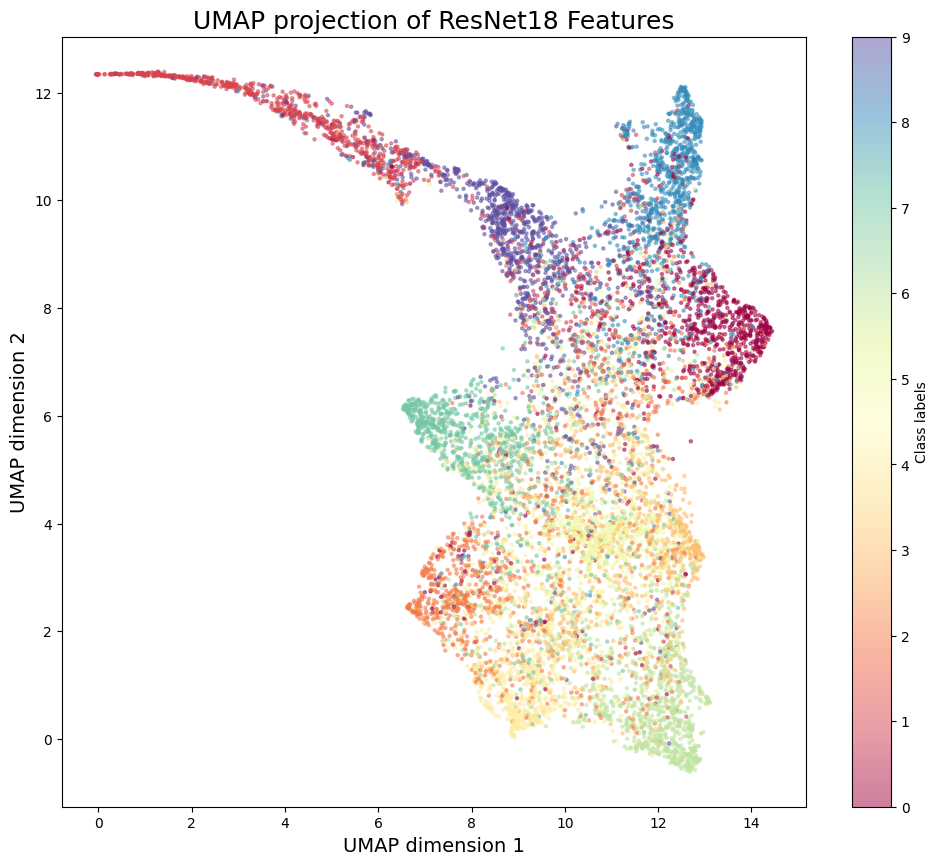

In [76]:
plot_umap(features,y_test)

###Q1.3 Adversarial Test (15 points)


In this section, you are required to change the unseen data before calculating the accuracy of them from the output image of the backbone. Compare the results with the previous section. Your changes should include data augmentations such as adding Gaussian noise, color jitter, etc. Additionally, you should apply an adversarial attack such as fast gradient method on the network. You can use the cleverhans library for this purpose.

In [77]:
augmentation = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.1*torch.randn_like(x)),  # Gaussian noise
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [78]:
def generate_fgm_examples(model, data_loader, criterion, epsilon=0.07, batch_size=64):
    model.eval()
    adv_examples = []
    adv_labels = []
    
    for inputs, labels in tqdm(data_loader, desc="Generating FGM Examples"):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs.requires_grad = True

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        model.zero_grad()
        loss.backward()
        
        # Generate adversarial examples
        adv_inputs = inputs + epsilon * inputs.grad.sign()
        adv_inputs = adv_inputs.detach()

        adv_examples.append(adv_inputs)
        adv_labels.append(labels)
    

    
    return adv_examples, adv_labels

In [95]:
adv_examples, adv_labels = generate_fgm_examples(model, test_loader, criterion)

adv_examples_tensor = torch.cat(adv_examples)
adv_labels_tensor = torch.cat(adv_labels)

# Create a adv_test TensorDataset
adv_dataset = TensorDataset(adv_examples_tensor, adv_labels_tensor)

# Create a DataLoader from the adv_test dataset
adv_data_loader = DataLoader(adv_dataset, batch_size=64, shuffle=False)

Generating FGM Examples: 100%|███████████████████████████████████████| 157/157 [00:03<00:00, 51.26it/s]


In [98]:
test_loss, test_accuracy = test(model, adv_data_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

   test: 100%|███████████████████████████████████████████████████████| 157/157 [00:01<00:00, 98.51it/s]

Test Loss: 14.8402, Test Accuracy: 2.30%


torch.Size([10000, 512])
torch.Size([10000])


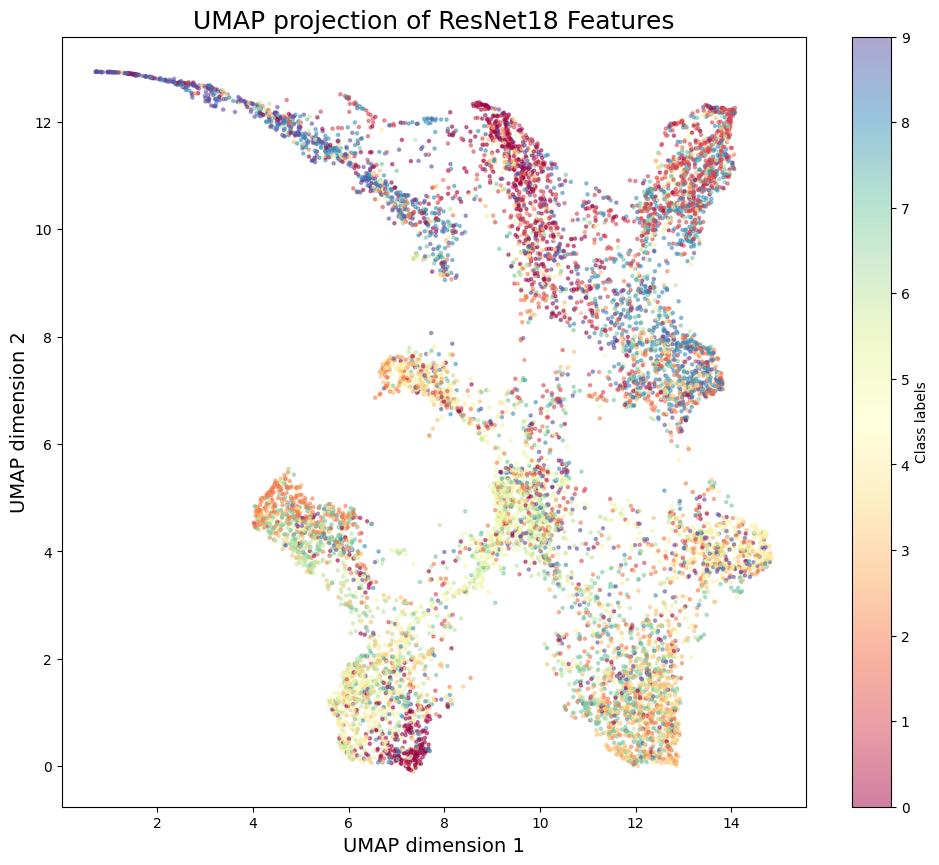

In [81]:
features, advy_test = get_features_and_labels(copied_model, adv_data_loader)
plot_umap(features,advy_test)

##Q1.4 Adversarial Train (20 points)


In this section, you should repeat the experiments on parts two and three using adversarial examples and compare the results. Here, the training data will be modified using augmentations and adversarial attack.

In [90]:
#use trained model from q1.2 to generate adv examples, then train a new model based on the examples
train_adv_examples, train_adv_lables = generate_fgm_examples(model, train_loader, criterion)

adv_examples_tensor = torch.cat(train_adv_examples)
adv_labels_tensor = torch.cat(train_adv_lables)

# Create a TensorDataset
adv_dataset = TensorDataset(adv_examples_tensor, adv_labels_tensor)

# Create a DataLoader from the TensorDataset
adv_data_train_loader = DataLoader(adv_dataset, batch_size=64, shuffle=True)

model2 = Resnet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_accuracy = train(model2, adv_data_train_loader, criterion, optimizer)
    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

Generating FGM Examples: 100%|███████████████████████████████████████| 157/157 [00:03<00:00, 50.74it/s]
/Users/kaihangjiang/anaconda3/envs/mps_general/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kaihangjiang/anaconda3/envs/mps_general/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.11it/s]


Epoch 1/30 - Training Loss: 1.8162, Training Accuracy: 33.91%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.73it/s]


Epoch 2/30 - Training Loss: 1.5455, Training Accuracy: 43.40%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.48it/s]


Epoch 3/30 - Training Loss: 1.3735, Training Accuracy: 50.86%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.63it/s]


Epoch 4/30 - Training Loss: 1.1934, Training Accuracy: 58.16%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.33it/s]


Epoch 5/30 - Training Loss: 0.9612, Training Accuracy: 66.69%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.11it/s]


Epoch 6/30 - Training Loss: 0.7476, Training Accuracy: 74.57%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.81it/s]


Epoch 7/30 - Training Loss: 0.5762, Training Accuracy: 80.41%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.34it/s]


Epoch 8/30 - Training Loss: 0.4465, Training Accuracy: 84.69%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.28it/s]


Epoch 9/30 - Training Loss: 0.3475, Training Accuracy: 88.16%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.77it/s]


Epoch 10/30 - Training Loss: 0.2724, Training Accuracy: 90.96%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.65it/s]


Epoch 11/30 - Training Loss: 0.2181, Training Accuracy: 92.29%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.87it/s]


Epoch 12/30 - Training Loss: 0.1769, Training Accuracy: 94.12%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.67it/s]


Epoch 13/30 - Training Loss: 0.2052, Training Accuracy: 92.66%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.72it/s]


Epoch 14/30 - Training Loss: 0.1317, Training Accuracy: 95.46%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.56it/s]


Epoch 15/30 - Training Loss: 0.1087, Training Accuracy: 96.33%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.92it/s]


Epoch 16/30 - Training Loss: 0.1016, Training Accuracy: 96.62%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.57it/s]


Epoch 17/30 - Training Loss: 0.1240, Training Accuracy: 95.92%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:07<00:00, 22.38it/s]


Epoch 18/30 - Training Loss: 0.0654, Training Accuracy: 98.03%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.35it/s]


Epoch 19/30 - Training Loss: 0.1391, Training Accuracy: 95.30%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.54it/s]


Epoch 20/30 - Training Loss: 0.1076, Training Accuracy: 96.49%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.85it/s]


Epoch 21/30 - Training Loss: 0.0877, Training Accuracy: 97.00%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.95it/s]


Epoch 22/30 - Training Loss: 0.0806, Training Accuracy: 97.31%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.77it/s]


Epoch 23/30 - Training Loss: 0.1029, Training Accuracy: 96.56%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 23.68it/s]


Epoch 24/30 - Training Loss: 0.0493, Training Accuracy: 98.38%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.27it/s]


Epoch 25/30 - Training Loss: 0.0936, Training Accuracy: 96.97%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.25it/s]


Epoch 26/30 - Training Loss: 0.0446, Training Accuracy: 98.41%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.55it/s]


Epoch 27/30 - Training Loss: 0.0416, Training Accuracy: 98.62%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.63it/s]


Epoch 28/30 - Training Loss: 0.0763, Training Accuracy: 97.37%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.49it/s]


Epoch 29/30 - Training Loss: 0.0587, Training Accuracy: 98.14%


   train: 100%|██████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.48it/s]

Epoch 30/30 - Training Loss: 0.0364, Training Accuracy: 98.78%


In [91]:
#val on normal data
val_loss, val_accuracy = test(model2, val_loader, criterion)
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

#test on normal data
test_loss, test_accuracy = test(model2, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

   test: 100%|███████████████████████████████████████████████████████| 625/625 [00:09<00:00, 68.49it/s]


Val Loss: 3.4891, Val Accuracy: 42.03%


   test: 100%|███████████████████████████████████████████████████████| 157/157 [00:02<00:00, 69.22it/s]

Test Loss: 3.5346, Test Accuracy: 41.18%


In [96]:
#test on adversarial examples
adv_test_loss, adv_test_accuracy = test(model2, adv_data_loader, criterion)
print(f"adv Test Loss: {adv_test_loss:.4f}, adv Test Accuracy: {adv_test_accuracy:.2f}%")

   test: 100%|███████████████████████████████████████████████████████| 157/157 [00:01<00:00, 93.49it/s]

adv Test Loss: 1.2009, adv Test Accuracy: 76.05%


torch.Size([10000, 512])
torch.Size([10000])


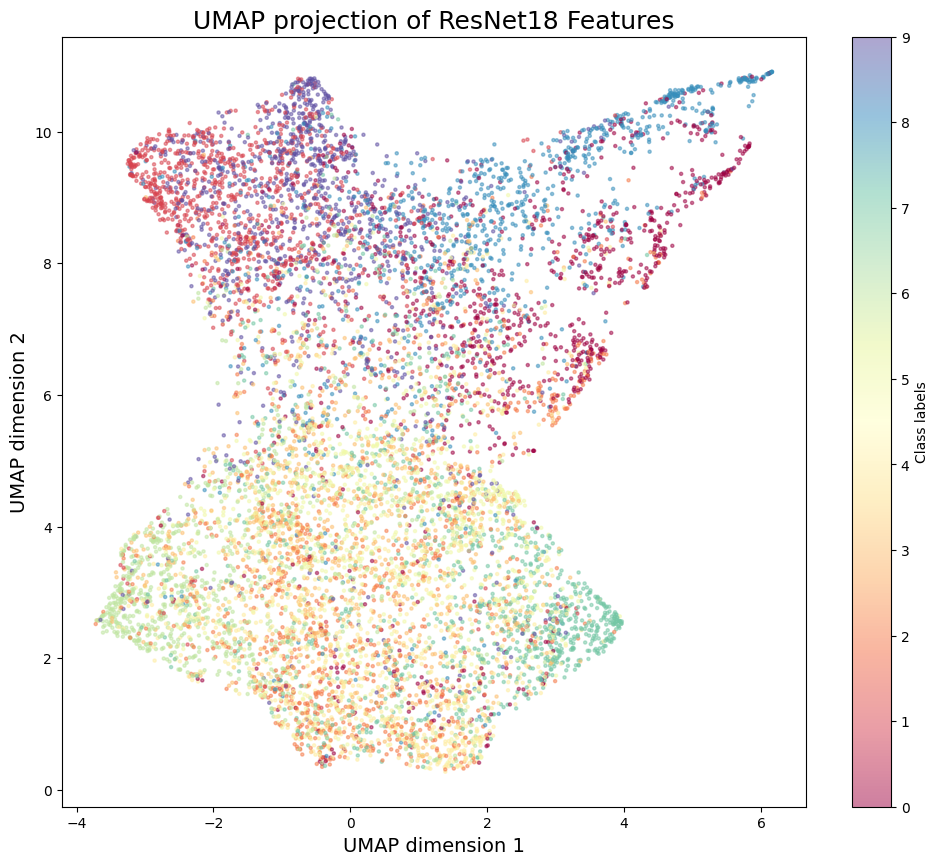

In [93]:
original_model = model2

copied_model = copy.deepcopy(original_model)
copied_model = original_model.__class__(num_classes=10)  # Create a new instance of the original model's class
copied_model.load_state_dict(original_model.state_dict())

copied_model.model.fc = Identity()
copied_model = copied_model.to(device) 

features, y_test = get_features_and_labels(copied_model, test_loader)
plot_umap(features,y_test) #normal plot

torch.Size([10000, 512])
torch.Size([10000])


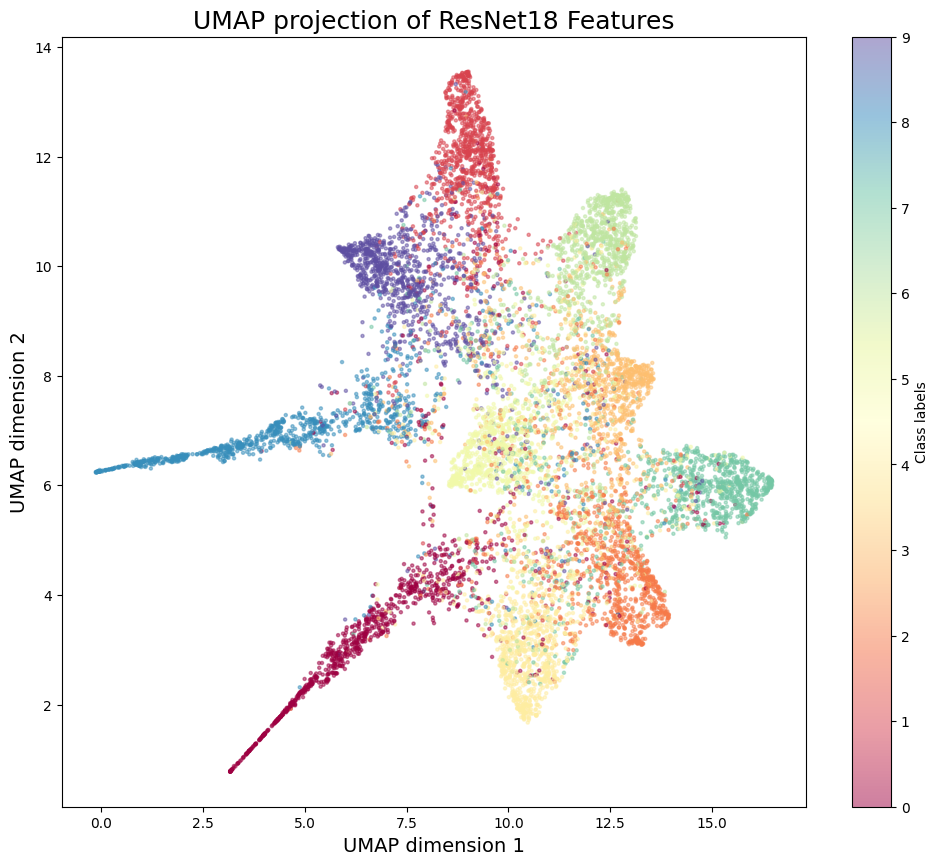

In [97]:
features, advy_test = get_features_and_labels(copied_model, adv_data_loader)
plot_umap(features,advy_test) #adv plot

##Question2 - Diffusion Model (45 points)

This homework helps you implement a Denoising Diffusion Probabilistic Model (DDPM).  



You can add any extra libraries that you need in this cell.

In [99]:
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import torch.nn as nn
from matplotlib import pyplot as plt
from PIL import Image
from keras.datasets import cifar10
from diffusers import UNet2DModel

###Q2.1 Load Data (5 points)

In this question, you are going to use one arbitrary class of CIFAR-10 dataset. First, load this dataset, then choose any class you want and use that for the rest of this question.

In [100]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

print(f"Using device: {device}")

Using device: mps


In [103]:
class CustomDataset(Dataset):
    def __init__(self, images, transform=None):
        #To do
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        #To do
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

# Choose a target class
target_class = 1  
class_indices = np.where(train_labels == target_class)[0]
class_images = train_images[class_indices]

# Creating a DataLoader for batching
batch_size = 64
custom_dataset = CustomDataset(class_images, transform=preprocess)
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [104]:
def show_images(x):
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = Image.fromarray(np.array(grid).astype(np.uint8))
    return grid

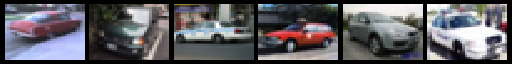

In [111]:
from IPython.display import display

x_test = next(iter(dataloader))[:6]
img_show = show_images(x_test).resize((8 * 64, 64), resample=Image.NEAREST)
display(img_show)

###Q2.2 Forward pass (10 points)

In this section, you are going to implement the forward pass of your diffusion model. You can use diffusers library for this task. Then use show_images function to plot your target image at different times of the forward pass. (Simply use the default hypermeters mentioned in the DDPM paper or the default values of the diffuser library. Visualising images every 100 steps is enough)

Step 0


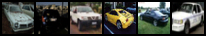

Step 100


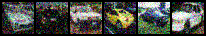

Step 200


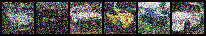

Step 300


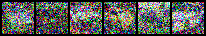

Step 400


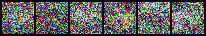

Step 500


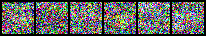

Step 600


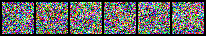

Step 700


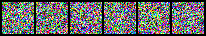

Step 800


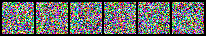

Step 900


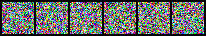

Step 1000


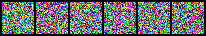

In [107]:
from IPython.display import display
from diffusers import DDPMScheduler

# Load a batch of images
x_test = next(iter(dataloader))
x_test = x_test.to(device)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
# timesteps = torch.tensor([1, 25, 50, 75, 100]) - 1  # Adjust for zero indexing
timesteps = torch.tensor([1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]) - 1  # Adjust for zero indexing

# Iterate over each desired timestep
for step, timestep in enumerate(timesteps):
    # Ensure timestep is in the correct shape and device
    timestep_tensor = torch.LongTensor([timestep.item()]).to(device)
    
    # Generate new noise for each timestep to simulate the diffusion process
    noise = torch.randn_like(x_test[:6]).to(device)
    
    # Add noise to the images at the specified timestep
    noisy_image = noise_scheduler.add_noise(x_test[:6], noise, timestep_tensor)

    print(f"Step {step * 100}")

    # Convert tensor to PIL Image for display
    noisy_img_show = show_images(noisy_image)
    display(noisy_img_show)

###Q2.3 Denoising (15 points)

In this section, you will implement the denoising part of your diffusion model. First, create a U-net and train it on your CIFAR10 data. Then, start from random noise and plot the denoised images of 6 random samples. (In the DDPM paper Sec 3.3, they also trained a reverse process decoder. You are not required to implement it in this assignment. Visualizing the outputs of the diffusion network is sufficient.)

In [108]:
model = UNet2DModel(
    sample_size=32,  # Assuming 32x32 images for CIFAR-10
    in_channels=3,   # 3 channels for RGB images
    out_channels=3,  # Outputting RGB images
    layers_per_block=2,  # Number of layers per block of the U-Net
    block_out_channels=(64, 128, 256, 512),  # Channels in the blocks of the U-Net
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

print(noise_scheduler.num_train_timesteps)

1000


/Users/kaihangjiang/anaconda3/envs/mps_general/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


In [109]:
def train(model,data_loader,criterion,optimizer):
    model.train()
    total_loss = 0
    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, inputs in enumerate(train_tqdm):
            # model.train()
            inputs = inputs.to(device)
            #To do
            noise = torch.randn(inputs.shape).to(device)
            rand_timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (inputs.shape[0],), device=device).long()            
            noisy_images = noise_scheduler.add_noise(inputs, noise, rand_timesteps)

            optimizer.zero_grad() 

            noise_pred = model(noisy_images, rand_timesteps, return_dict=False)[0]
            
            loss = criterion(noise_pred, noise)  # Using inputs as target since we're denoising

            loss.backward()
            total_loss += loss.item()
            optimizer.step()
    
    average_train_loss = total_loss / len(train_tqdm)
            
    return average_train_loss

criterion = nn.MSELoss()  # Mean Squared Error Loss is commonly used for denoising tasks
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 50
for epoch in range(epochs):
    avg_loss = train(model, dataloader, criterion, optimizer)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}")

   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:57<00:00,  1.37it/s]


Epoch 1/50, Average Loss: 0.26311392516274995


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 2/50, Average Loss: 0.09663083177955845


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 3/50, Average Loss: 0.07393621441118325


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.52it/s]


Epoch 4/50, Average Loss: 0.06505092096668255


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.52it/s]


Epoch 5/50, Average Loss: 0.05826701200272463


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.52it/s]


Epoch 6/50, Average Loss: 0.057095408286380614


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 7/50, Average Loss: 0.05535651064371761


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:53<00:00,  1.49it/s]


Epoch 8/50, Average Loss: 0.052642934212956245


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 9/50, Average Loss: 0.05296097080447251


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 10/50, Average Loss: 0.04995107827590236


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 11/50, Average Loss: 0.04959798835312264


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 12/50, Average Loss: 0.04974215847876253


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 13/50, Average Loss: 0.04752867923507208


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 14/50, Average Loss: 0.04834851492903655


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 15/50, Average Loss: 0.04745378642331196


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:53<00:00,  1.49it/s]


Epoch 16/50, Average Loss: 0.04466939698668975


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 17/50, Average Loss: 0.04486724536252927


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 18/50, Average Loss: 0.04395604152468186


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.52it/s]


Epoch 19/50, Average Loss: 0.04377734566791148


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.49it/s]


Epoch 20/50, Average Loss: 0.043295690412574174


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 21/50, Average Loss: 0.04501124868711716


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 22/50, Average Loss: 0.0421357800877547


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:51<00:00,  1.52it/s]


Epoch 23/50, Average Loss: 0.042972010619278196


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:53<00:00,  1.49it/s]


Epoch 24/50, Average Loss: 0.042459561642778074


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 25/50, Average Loss: 0.04114673970432221


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 26/50, Average Loss: 0.041038043938482864


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:53<00:00,  1.48it/s]


Epoch 27/50, Average Loss: 0.041257289061440695


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:51<00:00,  1.52it/s]


Epoch 28/50, Average Loss: 0.04043923209928259


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.52it/s]


Epoch 29/50, Average Loss: 0.04043827491187597


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 30/50, Average Loss: 0.04269957101514822


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 31/50, Average Loss: 0.04216100402836558


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 32/50, Average Loss: 0.04026636469496202


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.52it/s]


Epoch 33/50, Average Loss: 0.039718758409159095


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.52it/s]


Epoch 34/50, Average Loss: 0.03884519778097732


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.52it/s]


Epoch 35/50, Average Loss: 0.03855062144089349


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 36/50, Average Loss: 0.03881024055277245


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.49it/s]


Epoch 37/50, Average Loss: 0.03952901850489876


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.52it/s]


Epoch 38/50, Average Loss: 0.03998342922688285


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 39/50, Average Loss: 0.03892674853530111


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 40/50, Average Loss: 0.0405947210950942


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 41/50, Average Loss: 0.03754783077519151


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:51<00:00,  1.52it/s]


Epoch 42/50, Average Loss: 0.03706734071049509


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 43/50, Average Loss: 0.0377149838435499


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 44/50, Average Loss: 0.03841159886480132


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:51<00:00,  1.52it/s]


Epoch 45/50, Average Loss: 0.037210943177342415


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.51it/s]


Epoch 46/50, Average Loss: 0.03918820723325391


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:51<00:00,  1.53it/s]


Epoch 47/50, Average Loss: 0.03775620069118995


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 48/50, Average Loss: 0.03702288316680661


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]


Epoch 49/50, Average Loss: 0.04057805485363248


   train: 100%|████████████████████████████████████████████████████████| 79/79 [00:52<00:00,  1.50it/s]

Epoch 50/50, Average Loss: 0.03696274052409432


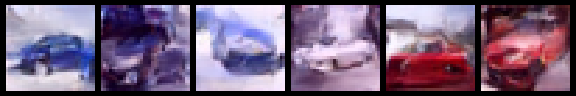

In [115]:
sample = torch.randn(6, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample).resize((6 * 96, 96), resample=Image.NEAREST)

###Q2.4 Conditional Equation (15 points)

In this part, you should express $\alpha_t$ in terms of the values of $\beta_i$, in the following equation:

$$q(z_t|z_0) = \mathcal{N}(z_t; \sqrt{\alpha_t}z_0, (1-\alpha_t)I)$$

Take this into account that the conditional variance for the one step forward diffusion (the following equation) at time t is given by $\beta_t$.

$$q(z_t|z_{t-1}) = \mathcal{N}(z_t; \sqrt{1-\beta_t}z_{t-1}, \beta_tI)$$

We define $\alpha'_t = 1 - \beta_t$,

$ \overline{\alpha}_t = \prod_{i=1}^{t}\alpha'_i $

For $$q(z_t|z_{t-1}) = \mathcal{N}(z_t; \sqrt{1-\beta_t}z_{t-1}, \beta_tI)$$, we can reparameterize this as 

$$z_t = \sqrt{1-\beta_t}z_{t-1} + \sqrt{\beta_t}\epsilon_{t-1} $$ where $$\epsilon_{t-1} \sim \mathcal{N}(0, I) $$

Sub in our defined $\alpha'_t$

$$z_t = \sqrt{\alpha'_t}z_{t-1} + \sqrt{1 - \alpha'_t}\epsilon_{t-1} $$

$$ = \sqrt{\alpha'_t\alpha'_{t-1}}z_{t-2} + \sqrt{1 - \alpha'_t}\epsilon_{t-1} $$

$$ =\sqrt{\alpha'_t}(\sqrt{\alpha'_{t-1}}z_{t-2}+\sqrt{1-\alpha'_{t-1}}\epsilon_{t-2})+\sqrt{1-\alpha'_t}\epsilon_{t-1} $$

$$ = ... $$

$$ = \sqrt{\overline{\alpha}_t}z_0 + \sqrt{1 - \overline{\alpha}_t}\epsilon_0 $$

We can see $$\overline{\alpha}_t = \alpha_t$$ where $\alpha_t$ is from $$q(z_t|z_0) = \mathcal{N}(z_t; \sqrt{\alpha_t}z_0, (1-\alpha_t)I)$$

Therefore,

$$ \alpha_t = \prod_{i=1}^{t}(1 - \beta_i) $$

This represents the cumulative retention of the original signal $z_0$ in $z_t$ after applying the diffusion process up to timestep $t$, with each $\beta_i$ indicating the noise added at step $i$.
